# Central Limit Theorem, Bootstrap, Standard Error and Confidence Intervals

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

We Use the Cumulative Database of Objects of Interest of the Kepler Exoplanet Observatory at https://exoplanetarchive.ipac.caltech.edu/docs/data.html

In this notebook we Illustrate how the Bootstrap Technique allows us to Determine the Central Limit Theorem

In [2]:
# Load the exoplanet database
data_url = "https://exoplanetarchive.ipac.caltech.edu/cgi-bin/nstedAPI/nph-nstedAPI?table=cumulative&select=kepid,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr&format=csv"
df_kepler = pd.read_csv(data_url)

Dataframe Cleaning

In [3]:
nans_per_column=df_kepler.isna().sum(axis=0)
nans_per_column

kepid                0
kepoi_name           0
koi_disposition      0
koi_period           0
koi_impact         363
koi_duration         0
koi_depth          363
koi_prad           363
koi_teq            363
koi_insol          321
koi_model_snr      363
dtype: int64

Drop All NaNs

In [4]:
df_kepler_clean=df_kepler.dropna().reset_index(drop=True)
df_kepler_clean

,kepid,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr
0,10797460,K00752.01,CONFIRMED,9.488036,0.146,2.95750,615.8,2.26,793.0,93.59,35.8
1,10797460,K00752.02,CONFIRMED,54.418383,0.586,4.50700,874.8,2.83,443.0,9.11,25.8
2,10811496,K00753.01,CANDIDATE,19.899140,0.969,1.78220,10829.0,14.60,638.0,39.30,76.3
3,10848459,K00754.01,FALSE POSITIVE,1.736952,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6
4,10854555,K00755.01,CONFIRMED,2.525592,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9
...,...,...,...,...,...,...,...,...,...,...,...
9196,10090151,K07985.01,FALSE POSITIVE,0.527699,1.252,3.22210,1579.2,29.35,2088.0,4500.53,453.3
9197,10128825,K07986.01,CANDIDATE,1.739849,0.043,3.11400,48.5,0.72,1608.0,1585.81,10.6
9198,10147276,K07987.01,FALSE POSITIVE,0.681402,0.147,0.86500,103.6,1.07,2218.0,5713.41,12.3
9199,10155286,K07988.01,CANDIDATE,333.486169,0.214,3.19900,639.1,19.30,557.0,22.68,14.0


## Filtering

In [5]:
def filter(df,col,iqr_score):
  iqr_col=df[col].quantile(0.75)-df[col].quantile(0.25)
  filter_lower=df[col]>df[col].quantile(0.25)-(iqr_col*iqr_score)
  filter_upper=df[col]<df[col].quantile(0.75)+(iqr_col*iqr_score)
  return df[filter_lower & filter_upper]

Filtered Dataframe with respect to Planetary Radius

In [6]:
df_filtered=df_kepler_clean.copy()
df_filtered=filter(df_kepler_clean,'koi_prad',2)

In [7]:
planet_radius_fil=df_filtered['koi_prad']

In First Place we define a function that takes 100,000 samples with replacement of size N, calculates the mean of each sample and stores the resulting means in a list

In [8]:
def sampling_means(x,N):
  means=[]
  for i in range(100_000):
    sample=x.sample(n=N,replace=True)
    means.append(sample.mean())
  return pd.Series(means)

We obtain the radius mean distribution of 100,000 samples of size 20% of the population total

In [9]:
means_radius=sampling_means(planet_radius_fil,int(np.floor(planet_radius_fil.size*0.2)))

[Text(0, 0.5, 'Probability Density')]

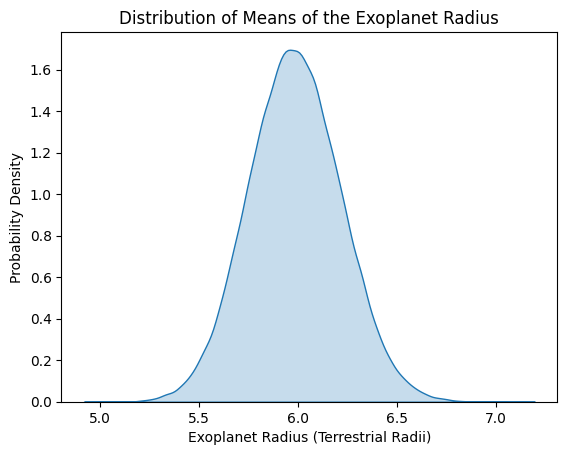

In [10]:
ax=sns.kdeplot(means_radius,fill=True)
ax.set_title ('Distribution of Means of the Exoplanet Radius')
ax.set(xlabel='Exoplanet Radius (Terrestrial Radii)')
ax.set(ylabel='Probability Density')

Skewness and Kurtosis

In [11]:
print(f'The Planet Radius Means Distribution Skewness is {means_radius.skew()}, and its relative Kurtosis is {means_radius.kurtosis()}')

The Planet Radius Means Distribution Skewness is 0.063082230658221, and its relative Kurtosis is 0.011667119431591821


Standard Error

From the above analysis we can conclude that the Distribution of means for the samples obtained by bootstraping is described by a normal distribution under a very good approximation, whose standard error is given by

In [12]:
means_radius.std()

0.23360749731005484

Which coincides with the estimate for this quantity that can be inferred from the standard deviation of the population and the size of the samples

In [13]:
planet_radius_fil.std()/np.sqrt(planet_radius_fil.size*0.2)

0.23397232896216555

Confidence Intervals

In [14]:
print(f'Confidence interval of 90% around the mean:{means_radius.quantile(0.05)}< {means_radius.mean()} <{means_radius.quantile(0.95)}')
print(f'Confidence interval of 95% around the mean:{means_radius.quantile(0.025)}< {means_radius.mean()} <{means_radius.quantile(0.975)}')
print(f'Confidence interval of 99% around the mean:{means_radius.quantile(0.005)}< {means_radius.mean()} <{means_radius.quantile(0.995)}')

Confidence interval of 90% around the mean:5.604385750156937< 5.983639734839925 <6.370254865034523
Confidence interval of 95% around the mean:5.5315688951663535< 5.983639734839925 <6.4471842435656
Confidence interval of 99% around the mean:5.394199435028248< 5.983639734839925 <6.601217984934086
